In [2]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from collections import Counter
import langdetect
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML

In [4]:
def load_articles(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            articles = json.load(file)
        print(f"{len(articles)} articles")
        return articles
    except Exception as e:
        print(f"Error: {e}")
        return []

In [5]:
articles = load_articles("cleaned_articles.json")

147029 articles


In [6]:
if articles:
    print("\nExample:")
    display(articles[450])


Example:


{'id': '20118',
 'url': 'https://badap.agh.edu.pl/publikacja/20118',
 'title': 'Wpływ nagniatania ślizgowego diamentem na zużycie ścierne stali węglowej konstrukcyjnej',
 'abstract': 'The Yickers method measuring the hardness of the treated layer is widely used, also in industrial applications. Due to the necessity of maintaining minimal distance between subsequent indentations the method inevitably generates inaccuracies.making elevation of resistance of elements against abrasion possible is a constituting in a manufacturing process, such features of top layer as high smoothness, a surface load capacity, the ability to maintenance of grease and high hardness. A technological operation making it possible to form these parameters, is burnishing with sliding diamond - element. In this presented work the results of initial researches on the wastes of abrasive samples, executed from steel 45, subjected to burnishing were introduced. With the aim of an estimation of the efficiency of this p

In [7]:
def has_valid_content(value, field=""):
    if not value:
        return False
    if isinstance(value, str):
            if field.lower() == "abstract" and value.lower().strip() in ["brak abstraktu"]:
                return False
            return len(value.strip()) > 0
    return bool(value)

In [8]:
fields_count = {
    'id': 0, 'url': 0, 'title': 0, 'abstract': 0, 
    'authors': 0, 'keywords': 0, 'publication_year': 0, 'publication_type': 0
}

In [9]:
for article in articles:
    for field in fields_count:
        if field in article and has_valid_content(article[field], field):
            fields_count[field] += 1

In [10]:
fields_coverage = pd.DataFrame({
            'Field': list(fields_count.keys()),
            'Number of articles with valid content': list(fields_count.values()),
            'Coverage (%)': [round(count / len(articles) * 100, 2) for count in fields_count.values()]
        })

In [11]:
display(fields_coverage)

,Field,Number of articles with valid content,Coverage (%)
0,id,147029,100.00
1,url,147029,100.00
2,title,147029,100.00
3,abstract,51815,35.24
4,authors,147029,100.00
5,keywords,53852,36.63
6,publication_year,147029,100.00
7,publication_type,147029,100.00


In [12]:
years = [article.get('publication_year', '') for article in articles 
         if 'publication_year' in article and article['publication_year']]

In [13]:
year_counts = Counter(years)

In [14]:
years_df = pd.DataFrame({
    'Year': list(year_counts.keys()),
    'Number of publications': list(year_counts.values())
}).sort_values('Year')

c:\Users\wehil\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\wehil\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


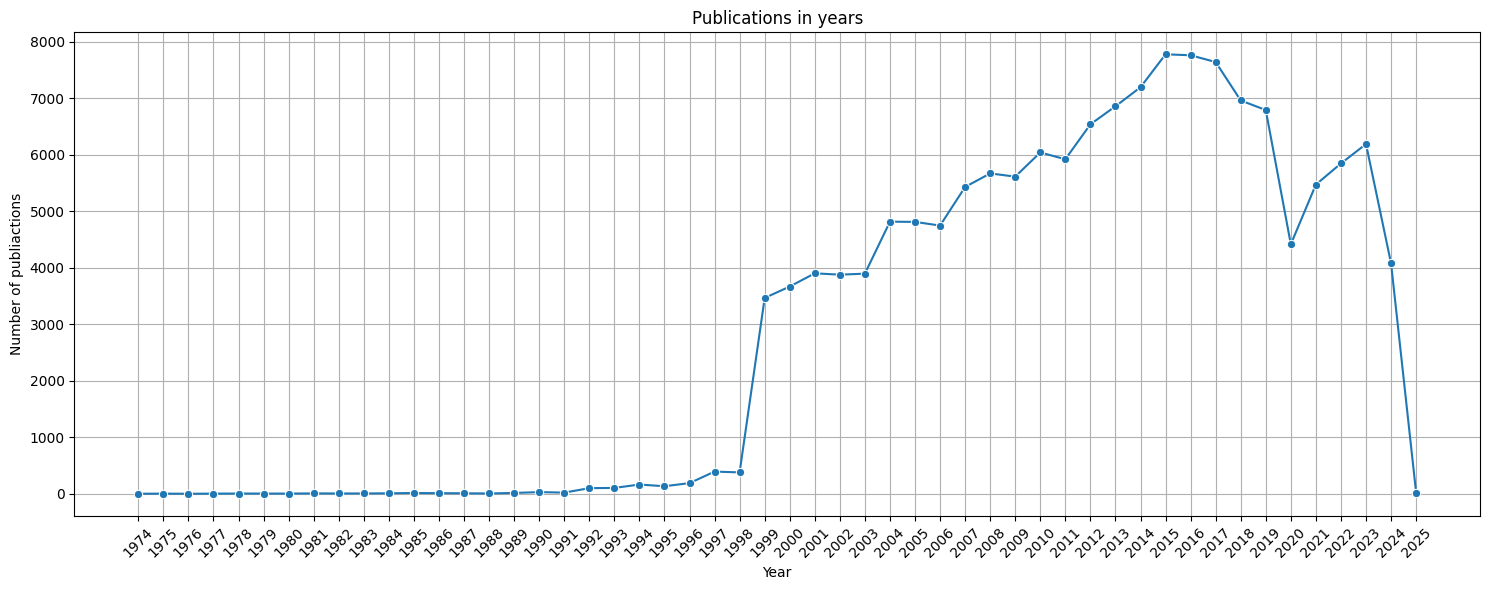

In [15]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Year', y='Number of publications', data=years_df, marker='o')
plt.title('Publications in years')
plt.xlabel('Year')
plt.ylabel('Number of publiactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
pub_types = [article.get('publication_type', '') for article in articles 
             if 'publication_type' in article and article['publication_type']]

In [17]:
pub_type_counts = Counter(pub_types)

In [18]:
pub_types_df = pd.DataFrame({
    'Type of publication': list(pub_type_counts.keys()),
    'Number of publications': list(pub_type_counts.values())
}).sort_values('Number of publications', ascending=False)

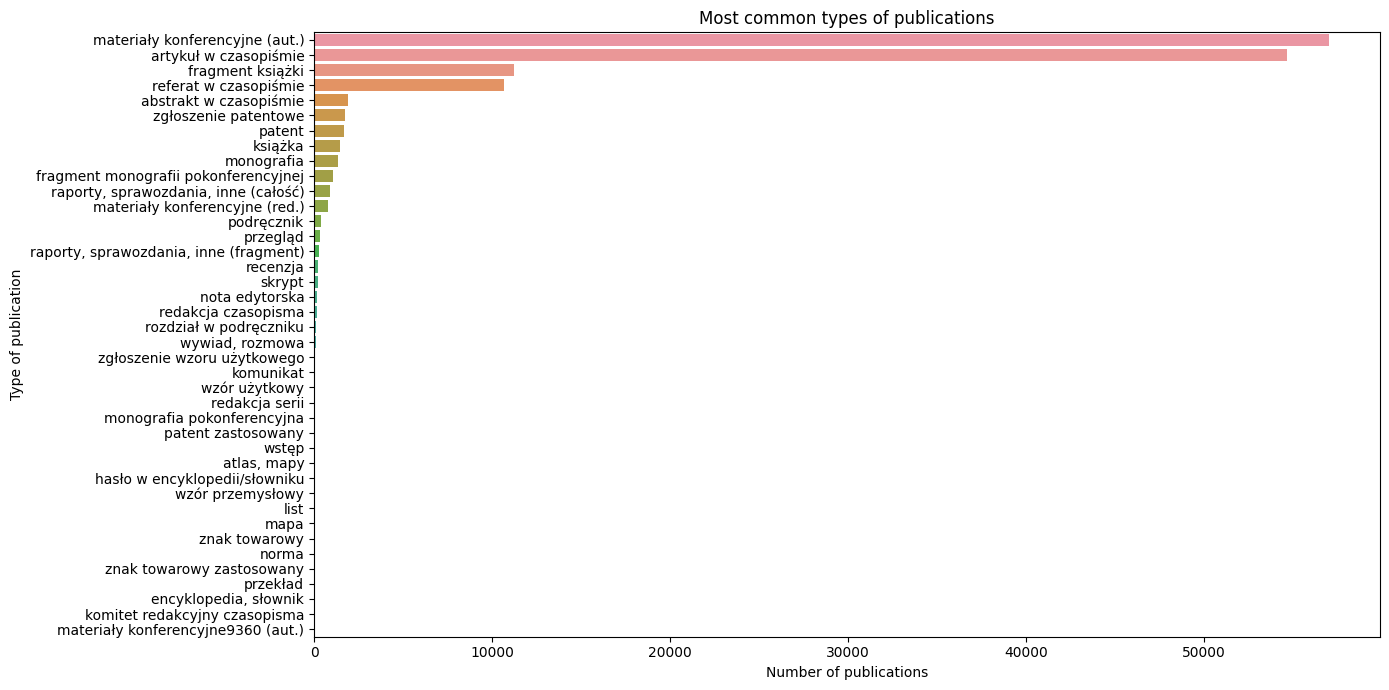

In [19]:
plt.figure(figsize=(14, 7))
sns.barplot(x='Number of publications', y='Type of publication', data=pub_types_df.head(100))
plt.title('Most common types of publications')
plt.xlabel('Number of publications')
plt.tight_layout()
plt.show()

In [20]:
title_lengths = [len(article.get('title', '')) for article in articles
                if 'title' in article and has_valid_content(article['title'])]

In [21]:
abstract_lengths = [len(article.get('abstract', '')) for article in articles
                   if 'abstract' in article and has_valid_content(article['abstract'], 'abstract')]

In [22]:
title_lengths_stats = {
    'min': np.min(title_lengths),
    'max': np.max(title_lengths),
    'mean': np.mean(title_lengths),
    'median': np.median(title_lengths),
    'std': np.std(title_lengths)
}

In [23]:
abstract_lengths_stats = {
    'min': np.min(abstract_lengths),
    'max': np.max(abstract_lengths),
    'mean': np.mean(abstract_lengths),
    'median': np.median(abstract_lengths),
    'std': np.std(abstract_lengths)
}

In [24]:
print("\nTitle length statistics (characters):")
display(pd.DataFrame([title_lengths_stats]))


Title length statistics (characters):


,min,max,mean,median,std
0,3,372,83.345619,80.0,33.558816


In [25]:
print("\nAbstract length statistics (characters):")
display(pd.DataFrame([abstract_lengths_stats]))


Abstract length statistics (characters):


,min,max,mean,median,std
0,26,9376,1021.525388,947.0,500.866839


In [26]:
author_counts_per_article = []
all_authors = []

In [27]:
for article in articles:
    if 'authors' in article and has_valid_content(article['authors']):
        authors = article['authors']
        if isinstance(authors, list):
            author_counts_per_article.append(len(authors))
            all_authors.extend(authors)
        elif isinstance(authors, str):
            author_list = authors.split(',')
            author_counts_per_article.append(len(author_list))
            all_authors.extend(author_list)

In [28]:
author_counts_stats = {
    'min': np.min(author_counts_per_article),
    'max': np.max(author_counts_per_article),
    'mean': np.mean(author_counts_per_article),
    'median': np.median(author_counts_per_article),
    'std': np.std(author_counts_per_article)
}

In [29]:
print("\nStatistics on number of authors per publication:")
display(pd.DataFrame([author_counts_stats]))


Statistics on number of authors per publication:


,min,max,mean,median,std
0,1,38,2.221861,2.0,1.819432


In [30]:
top_authors = Counter(all_authors).most_common(20)
top_authors_df = pd.DataFrame(top_authors, columns=['Author', 'Number of Publications'])

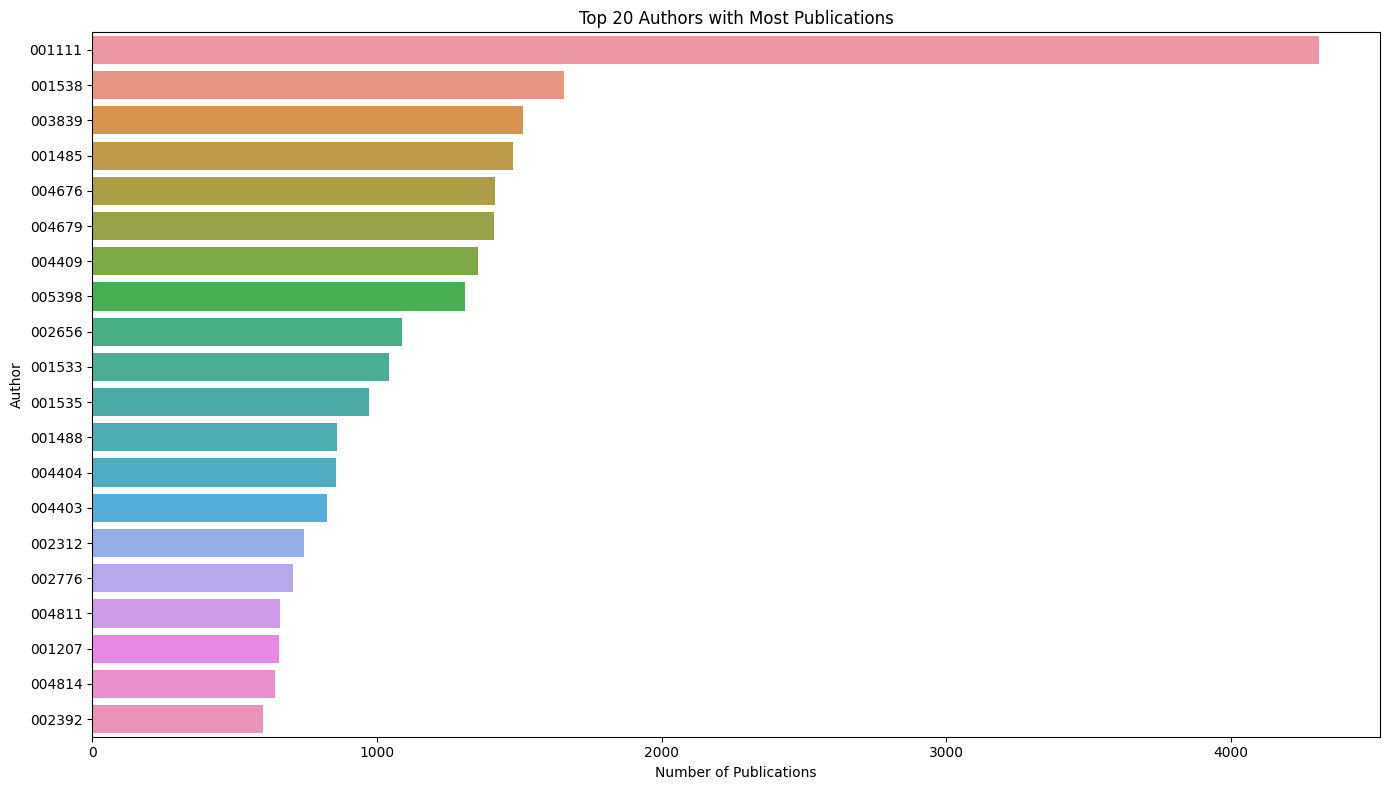

In [31]:
plt.figure(figsize=(14, 8))
sns.barplot(x='Number of Publications', y='Author', data=top_authors_df)
plt.title('Top 20 Authors with Most Publications')
plt.xlabel('Number of Publications')
plt.tight_layout()
plt.show()

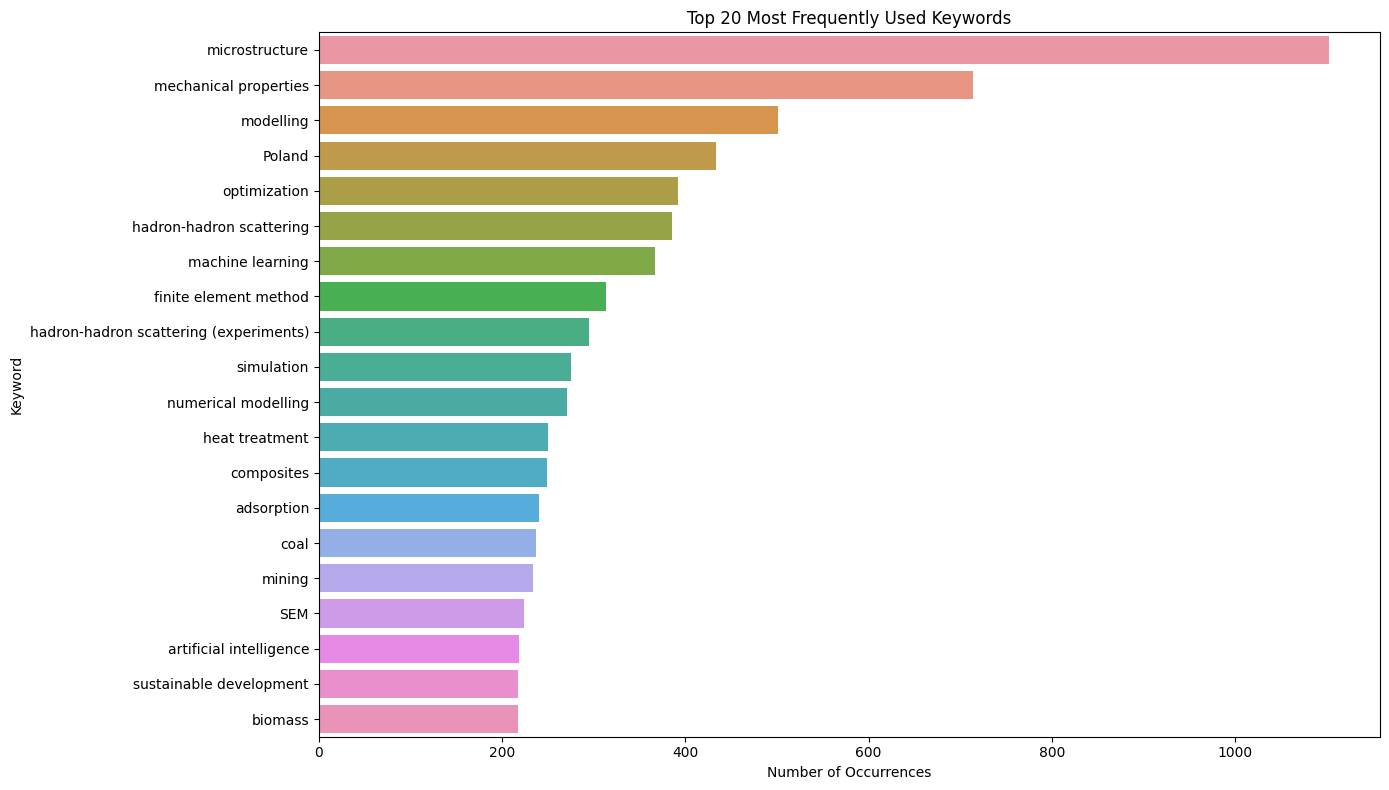

In [32]:
all_keywords = []

for article in articles:
    if 'keywords' in article and has_valid_content(article['keywords']):
        keywords = article['keywords']
        if isinstance(keywords, list):
            all_keywords.extend(keywords)
        elif isinstance(keywords, str):
            keyword_list = keywords.split(',')
            all_keywords.extend([k.strip() for k in keyword_list])

top_keywords = Counter(all_keywords).most_common(30)
top_keywords_df = pd.DataFrame(top_keywords, columns=['Keyword', 'Occurrences'])

plt.figure(figsize=(14, 8))
sns.barplot(x='Occurrences', y='Keyword', data=top_keywords_df.head(20))
plt.title('Top 20 Most Frequently Used Keywords')
plt.xlabel('Number of Occurrences')
plt.tight_layout()
plt.show()

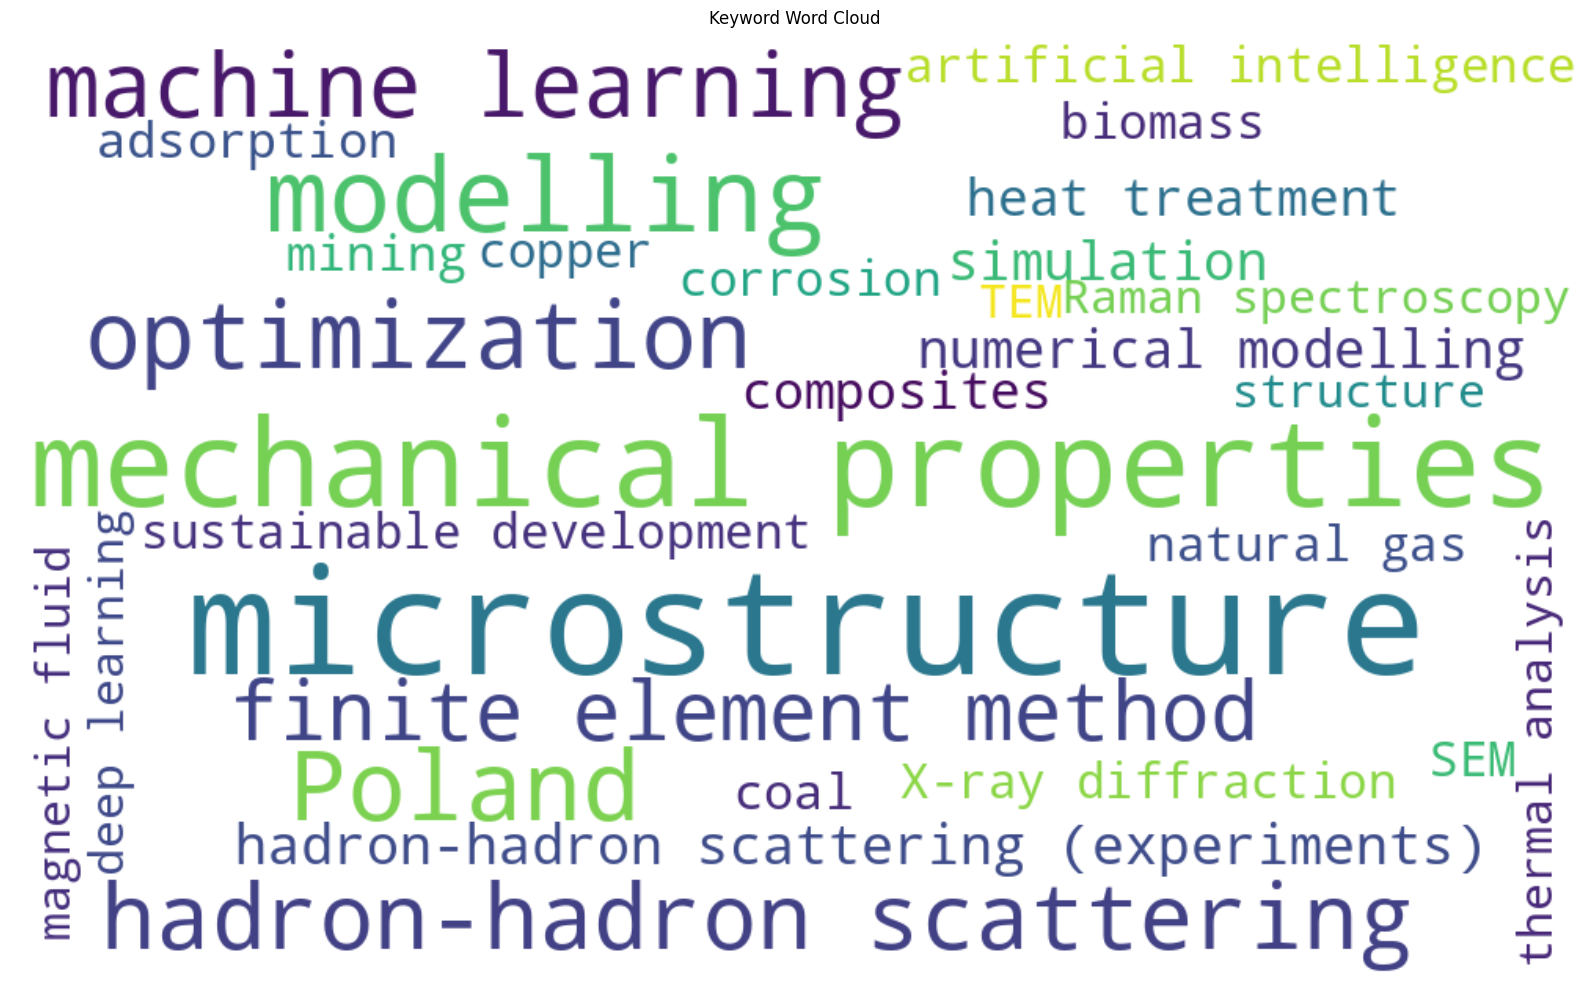

In [33]:
wordcloud = WordCloud(width=1000, height=600, background_color='white', 
                     max_words=100, contour_width=3, contour_color='black')
wordcloud.generate_from_frequencies(dict(top_keywords))

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud')
plt.tight_layout()
plt.show()